## Libraries

Here are some common libraries you'll probably want to use. [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html) is a common library for analyzing single-cell RNA-seq (and a [classic tutorial on 3K cells](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)). [AnnData](https://anndata.readthedocs.io/en/latest/) is a common data format. Feel free to use others as well.
For the AutoEncoder use pytorch.

In [1]:
#!pip install anndata scanpy

In [2]:
import anndata as ad
import scanpy as sc

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim




from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, make_scorer, confusion_matrix, f1_score, silhouette_score
from sklearn.dummy import DummyClassifier
import shap

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

{p.__name__: p.__version__ for p in [ad, sc]}

/Users/edenzohar/Projects/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'anndata': '0.10.9', 'scanpy': '1.10.2'}

In [3]:
!curl -o dataset.h5ad "https://datasets.cellxgene.cziscience.com/dfcfc59c-b654-435b-a5c8-53855bf0331a.h5ad"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  427M  100  427M    0     0  27.7M      0  0:00:15  0:00:15 --:--:-- 28.6M5  427M   45  193M    0     0  26.6M      0  0:00:16  0:00:07  0:00:09 28.6M  427M   65  281M    0     0  27.4M      0  0:00:15  0:00:10  0:00:05 28.4M


In [4]:
adata = ad.read_h5ad('dataset.h5ad')
adata.shape

(76567, 33145)

We see that we have ~76.5K cells across ~33K genes. The (sparse) gene expression data is stored in the `X` variable:

In [5]:
adata.X.shape, adata.X.dtype, adata.X.__class__

((76567, 33145), dtype('float32'), scipy.sparse._csr.csr_matrix)

We also have metadata for each individual cell:

In [6]:
adata.obs.head(3)

,mapped_reference_assembly,mapped_reference_annotation,alignment_software,donor_id,self_reported_ethnicity_ontology_term_id,donor_living_at_sample_collection,donor_menopausal_status,organism_ontology_term_id,sample_uuid,sample_preservation_method,...,reported_diseases,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
r1_hbca_c01_CTAGTGAGTACTCAAC,GRCh38,GENCODE 28,Cell Ranger count v3.1.0,P01,HANCESTRO:0005,True,postmenopausal,NCBITaxon:9606,c4a63080-974c-4eb1-9c40-7c6f93f65de6,n/a (fresh),...,breast cancer,mature NK T cell,10x 3' v2,normal,Homo sapiens,female,breast,European,mature stage,ql=%!_ZqPi
r1_hbca_c03_ACGATACGTACCAGTT,GRCh38,GENCODE 28,Cell Ranger count v3.1.0,P02,HANCESTRO:0005,True,premenopausal,NCBITaxon:9606,65eb6de4-ee12-436b-9c8e-0791e09fd88d,n/a (fresh),...,breast cancer,"effector memory CD8-positive, alpha-beta T cell",10x 3' v2,normal,Homo sapiens,female,breast,European,mature stage,d?|_T^;32!
r1_hbca_c03_AGCCTAAAGCGTCAAG,GRCh38,GENCODE 28,Cell Ranger count v3.1.0,P02,HANCESTRO:0005,True,premenopausal,NCBITaxon:9606,65eb6de4-ee12-436b-9c8e-0791e09fd88d,n/a (fresh),...,breast cancer,"effector memory CD8-positive, alpha-beta T cell",10x 3' v2,normal,Homo sapiens,female,breast,European,mature stage,>C<wMHASXf


Some of the most interesting metadata are
- `cell_type`
- `sample_id`
- `donor_id`
- `assay`
- `disease` or 'reported_diseases' (notice that they were having data curation issues with the disease column in which every cell seemed normal
- `development_stage`

You can look at the number of cells for each metadata value of a given column via

In [7]:
adata.obs['disease'].value_counts() 
adata.obs['reported_diseases'].value_counts()  # in case disease doesn't work

reported_diseases
none             56013
breast cancer    20554
Name: count, dtype: int64

#### Data quality control

I will start with some visualization of the data. Including the classical quality control metrics like: 
 1) Number of expressed genes in each cell (unique genes): Cells with very few detected genes could be low-quality cells (e.g., dead or damaged), while cells with too many detected genes might be doublets (two or more cells sequenced together).
 2) Number of Counts per cell (sum of expression): Low counts could indicate poor quality cells with insufficient RNA (e.g., dying cells), while excessively high counts might signal cell doublets.
 3) Mitochondrial Gene Expression: A high percentage of mitochondrial RNA suggests that the cell is likely damaged or undergoing apoptosis. A typical threshold to filter out cells with high mitochondrial gene counts is around 5-10%.

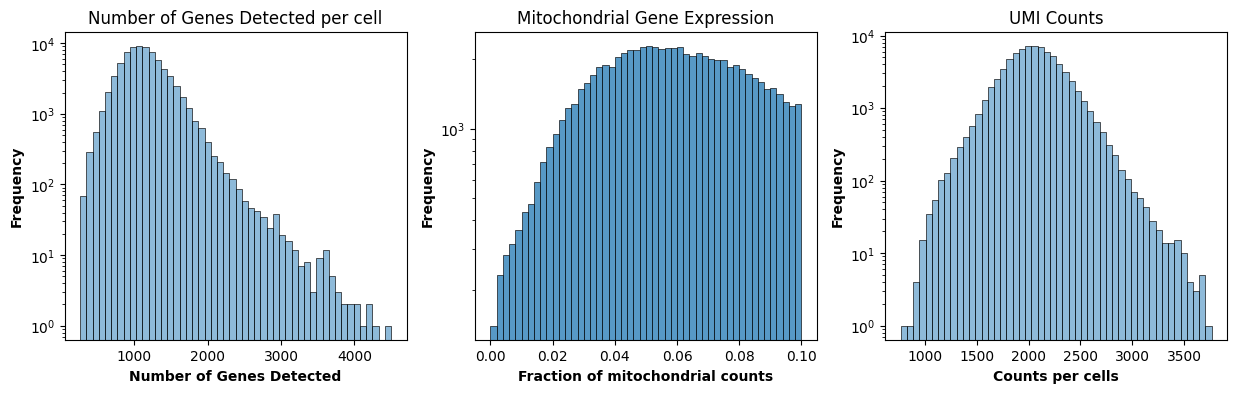

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))


num_genes_per_cell = (adata.X > 0).sum(axis=1)
sns.histplot(num_genes_per_cell, bins=50, legend=False, ax = axes[0])
axes[0].set_xlabel("Number of Genes Detected", weight="bold")
axes[0].set_ylabel("Frequency", weight="bold")
axes[0].set_yscale("log")
axes[0].set_title("Number of Genes Detected per cell")

pct_mito = adata.obs["percent_mito"].values
sns.histplot(pct_mito, bins=50, legend=False, ax=axes[1])
axes[1].set_xlabel("Fraction of mitochondrial counts", weight="bold")
axes[1].set_ylabel("Frequency", weight="bold")
axes[1].set_yscale("log")
axes[1].set_title("Mitochondrial Gene Expression")

adata_x_array = adata.X.toarray()
total_counts_per_barcode = np.sum(adata.X, axis=1)
sns.histplot(total_counts_per_barcode, bins=50, legend=False, ax=axes[2])
axes[2].set_xlabel("Counts per cells", weight="bold")
axes[2].set_ylabel("Frequency", weight="bold")
axes[2].set_yscale("log")
axes[2].set_title("UMI Counts");

1) It looks like the number of genes detected per cell doesn't have any extreme high or low values, no need for filtering on this feature. 
2) The cells with a fractions of mitochondrial counts above 10% have been cutoff, so no need to filter out these cells. 
3) The UMI counts, similarly to the number of genes detective, doesn't have any extreme values, the tails have been filtered out. 

It looks like this data is already filtered, so i will only filter on highly expressed genes to decrease dimensionality. 

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True)
print(f"Total number of genes after variability cutoff {adata.X.shape[1]}")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Total number of genes after variability cutoff 2000


#### Normalization:

1) Total Count Normalization: This step makes sure that differences in gene expression levels between cells reflect biological variation rather than technical artifacts. By normalizing, we adjust the raw counts so that each cell has the same total expression, allowing us to compare gene expression levels between cells fairly.
2) Log Transformation: Raw counts in single-cell RNA-seq data typically follow a skewed distribution, where most genes have low expression values, and a few genes have very high expression levels. This makes it hard to capture the full range of variation in downstream analyses. Applying a log transformation gives low-expressed genes a better representation while high-expressed genes are scaled down.

In [10]:
adata.layers["counts"] = adata.X.copy()  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Feature exploration: 

First checking to see how imbalanced the data is  

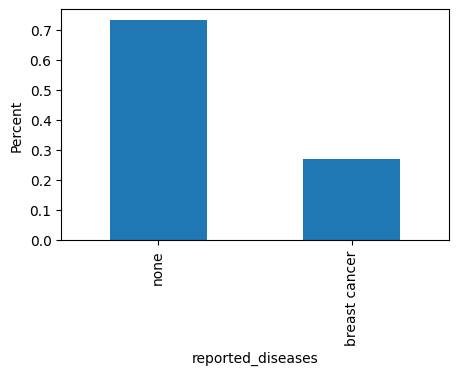

In [11]:
adata.obs.reported_diseases.value_counts(normalize=True).plot(kind='bar',ylabel='Percent',figsize=(5,3));

Looks like there is a pretty high imbalance, 70/30 percent. To deal with this I will use stratified kfold and maybe up/down sampling methods if needed.. 

#### Donor ID 

Explore the distributions of donor ID's, and the heterogeneity between cell types 

In [12]:
print(f"Total of {adata.obs.donor_id.nunique()} donors ")

Total of 126 donors 


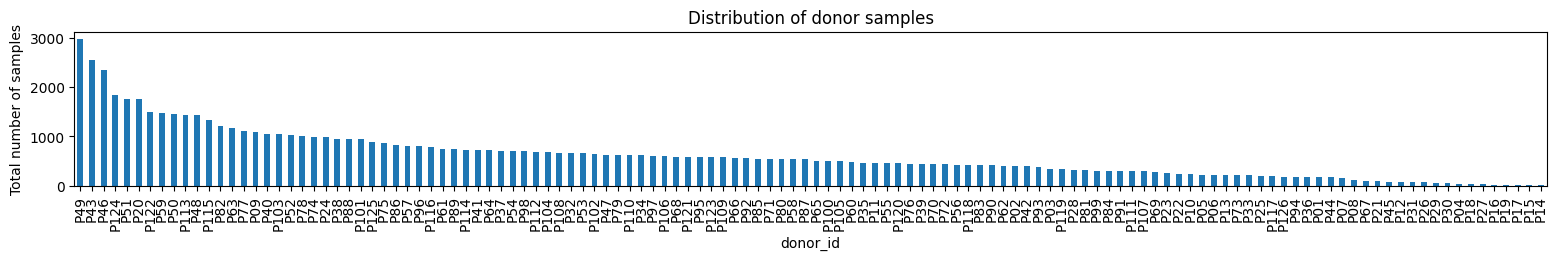

In [13]:
adata.obs.donor_id.value_counts().plot(kind='bar',ylabel='Total number of samples',figsize=(19,2),title='Distribution of donor samples');

Looks like the donor samples have a skewed distribution

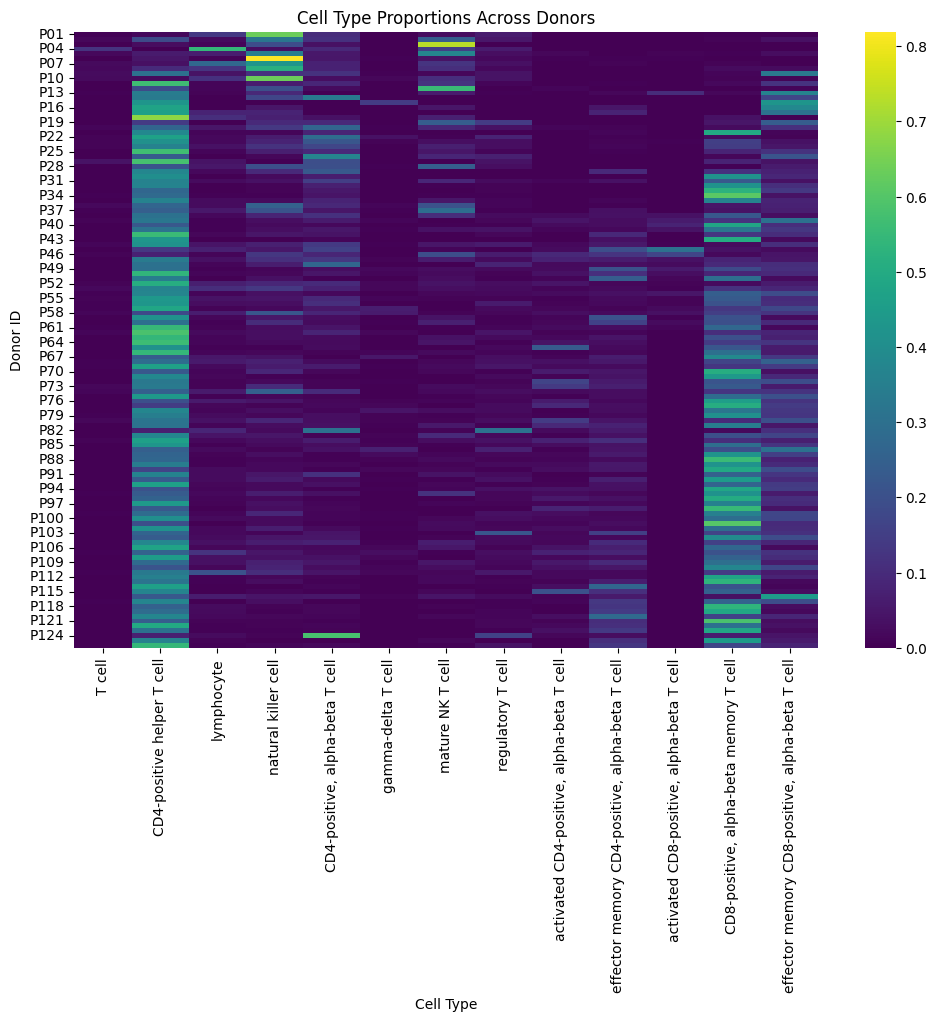

In [14]:
# Calculate cell type counts for each donor
donor_celltype_counts = adata.obs.groupby(['donor_id', 'cell_type']).size().unstack(fill_value=0)

# Normalize within donors to get proportions
donor_celltype_proportions = donor_celltype_counts.div(donor_celltype_counts.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(donor_celltype_proportions, cmap='viridis', annot=False, cbar=True)
plt.title('Cell Type Proportions Across Donors')
plt.xlabel('Cell Type')
plt.ylabel('Donor ID')
plt.show()

Lets try to quantify the differences in cell type distribution between donors with a chi-square test

In [15]:
contingency_table = adata.obs.groupby(['donor_id', 'cell_type']).size().unstack(fill_value=0)
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f'Chi2: {chi2}, p-value: {p_value}')

Chi2: 79194.70380935859, p-value: 0.0


It looks like two cell types are more common in the data (CD4-positive helper T cell, CD8-positive alpha beta memory T cell). There is some heterogeneity between donor in the natural killer cells, where a few donors have a high expression and the rest do not. From the chi-test results, it looks like the distributions are significantly different in cell type abundance. 

#### Features that could cause batch effects:

In [16]:
print(f'Total of {adata.obs.sample_id.nunique()} sample ids')

Total of 167 sample ids


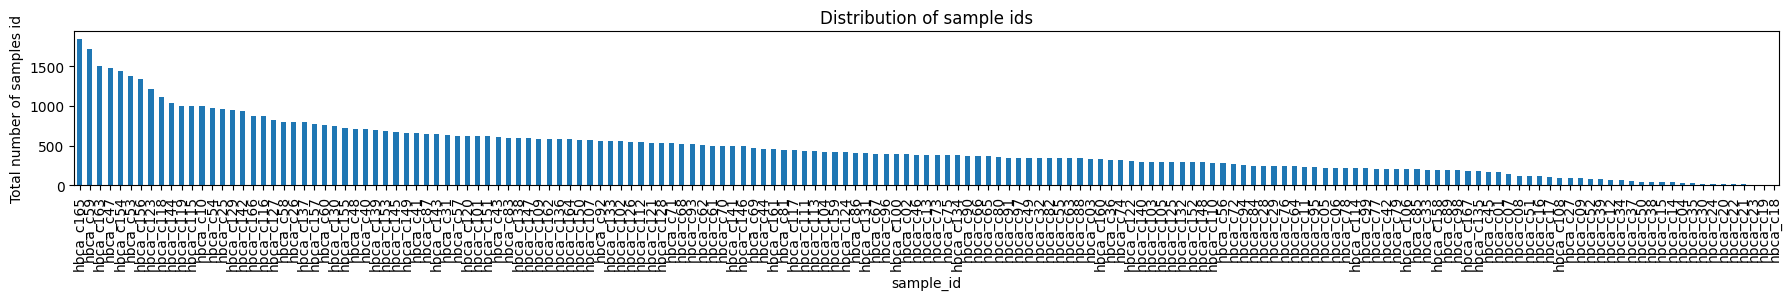

In [17]:
adata.obs.sample_id.value_counts().plot(kind='bar',ylabel='Total number of samples id',figsize=(22,2),title='Distribution of sample ids');

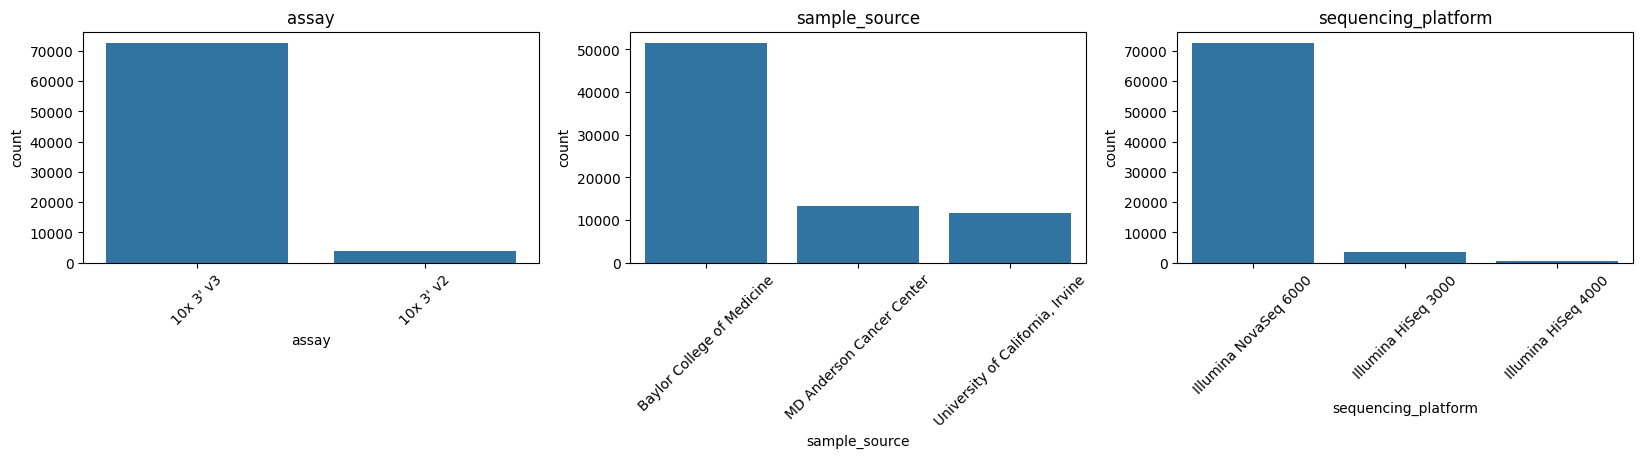

In [18]:
categorical_vars = ['assay', 'sample_source','sequencing_platform']
fig,axis = plt.subplots(1,3,figsize=(20,3))
axis=axis.ravel()
for id,var in enumerate(categorical_vars):
    sns.countplot(x=var, data=adata.obs, order=adata.obs[var].value_counts().index,ax=axis[id])
    axis[id].set_title(var)
    axis[id].set_xticklabels(axis[id].get_xticklabels(),rotation=45)

To look deeper into the influence of the batch effects on the data I will plot a PCA for each feature. If cells from different batches (e.g., different assays or sequencing methods) form distinct clusters, this suggests batch effects.

In [19]:
def balance_adata_by_feature(adata, feature):
    group_counts = adata.obs.groupby(feature).size()
    min_group_size = group_counts.min()
    subsample_indices = []

    for category, _ in group_counts.items():
        group_indices = adata.obs[adata.obs[feature] == category].index

        subsampled_group_indices = np.random.choice(group_indices, size=min(min_group_size, len(group_indices)), replace=False)
        subsample_indices.extend(subsampled_group_indices)

    adata_balanced = adata[subsample_indices].copy()

    return adata_balanced

adata_balanced_assay = balance_adata_by_feature(adata, 'assay')
adata_balanced_sample_source = balance_adata_by_feature(adata, 'sample_source')
adata_balanced_sequencing_platform = balance_adata_by_feature(adata, 'sequencing_platform')

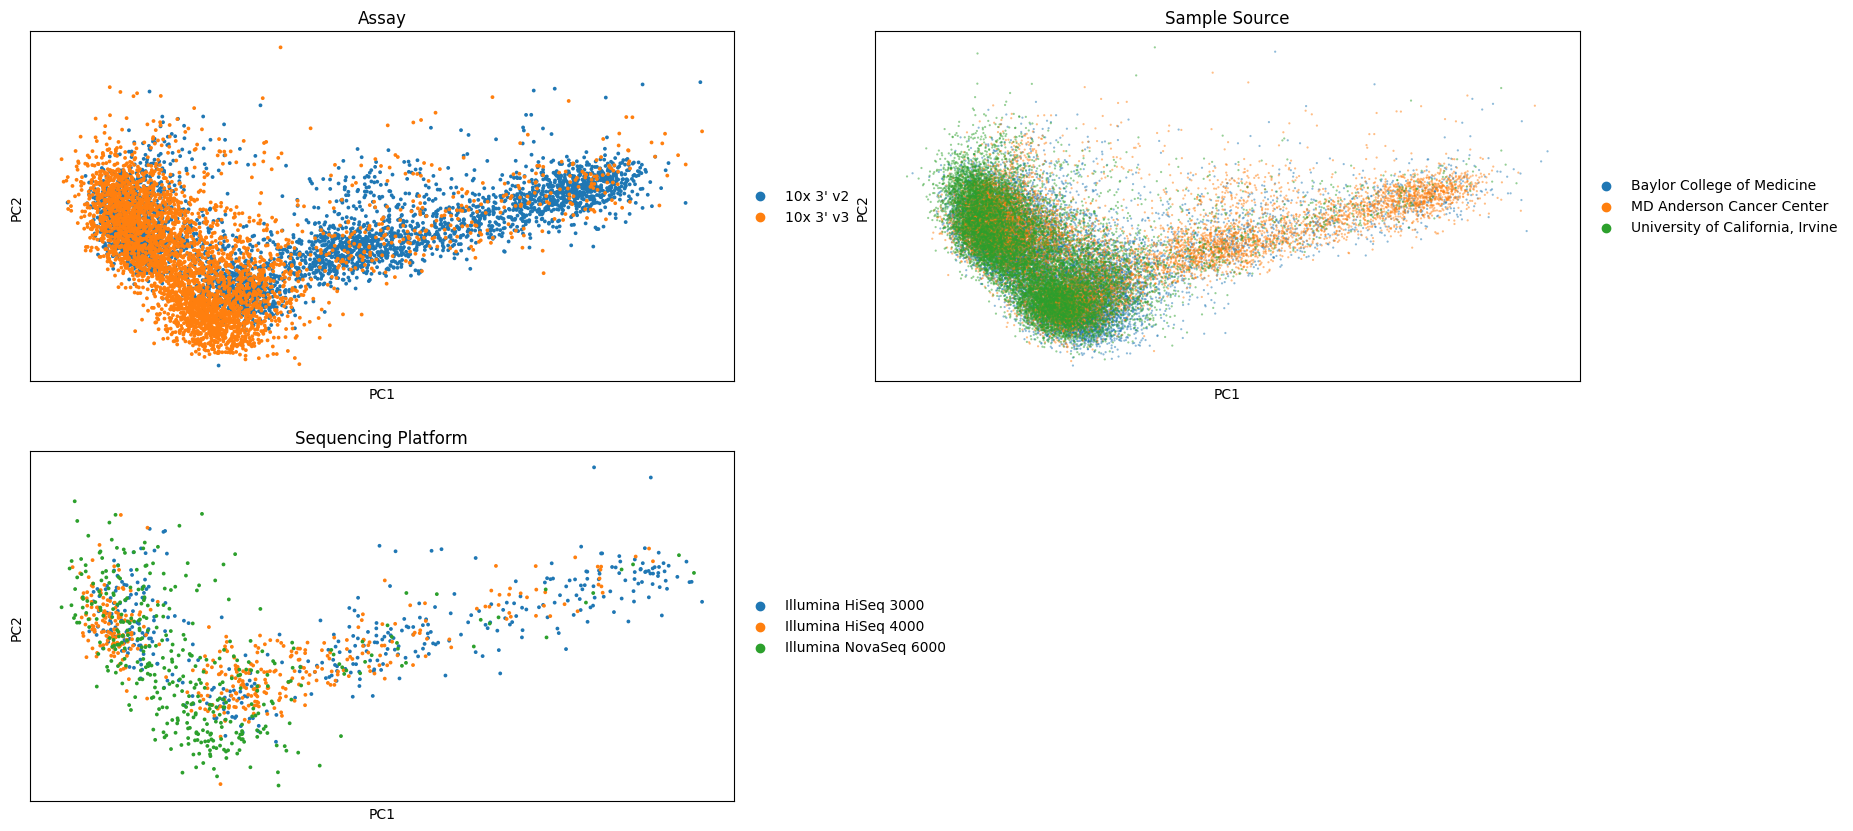

In [20]:
marker_size = 30

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()
sc.pl.pca(adata_balanced_assay, color='assay', ax=axes[0], size=marker_size, show=False)
axes[0].set_title('Assay')

sc.pl.pca(adata_balanced_sample_source, color='sample_source', ax=axes[1], size=10, show=False,alpha=0.5)
axes[1].set_title('Sample Source')

sc.pl.pca(adata_balanced_sequencing_platform, color='sequencing_platform', ax=axes[2], size=marker_size, show=False)
axes[2].set_title('Sequencing Platform')

axes[3].axis('off');

Looks like there is some batch effect, mostly in the `assay` and `sample_source` features. Also it looks like most of the assay v2 came from MD cancer center.

#### Looking into some background information about the donors and cells:

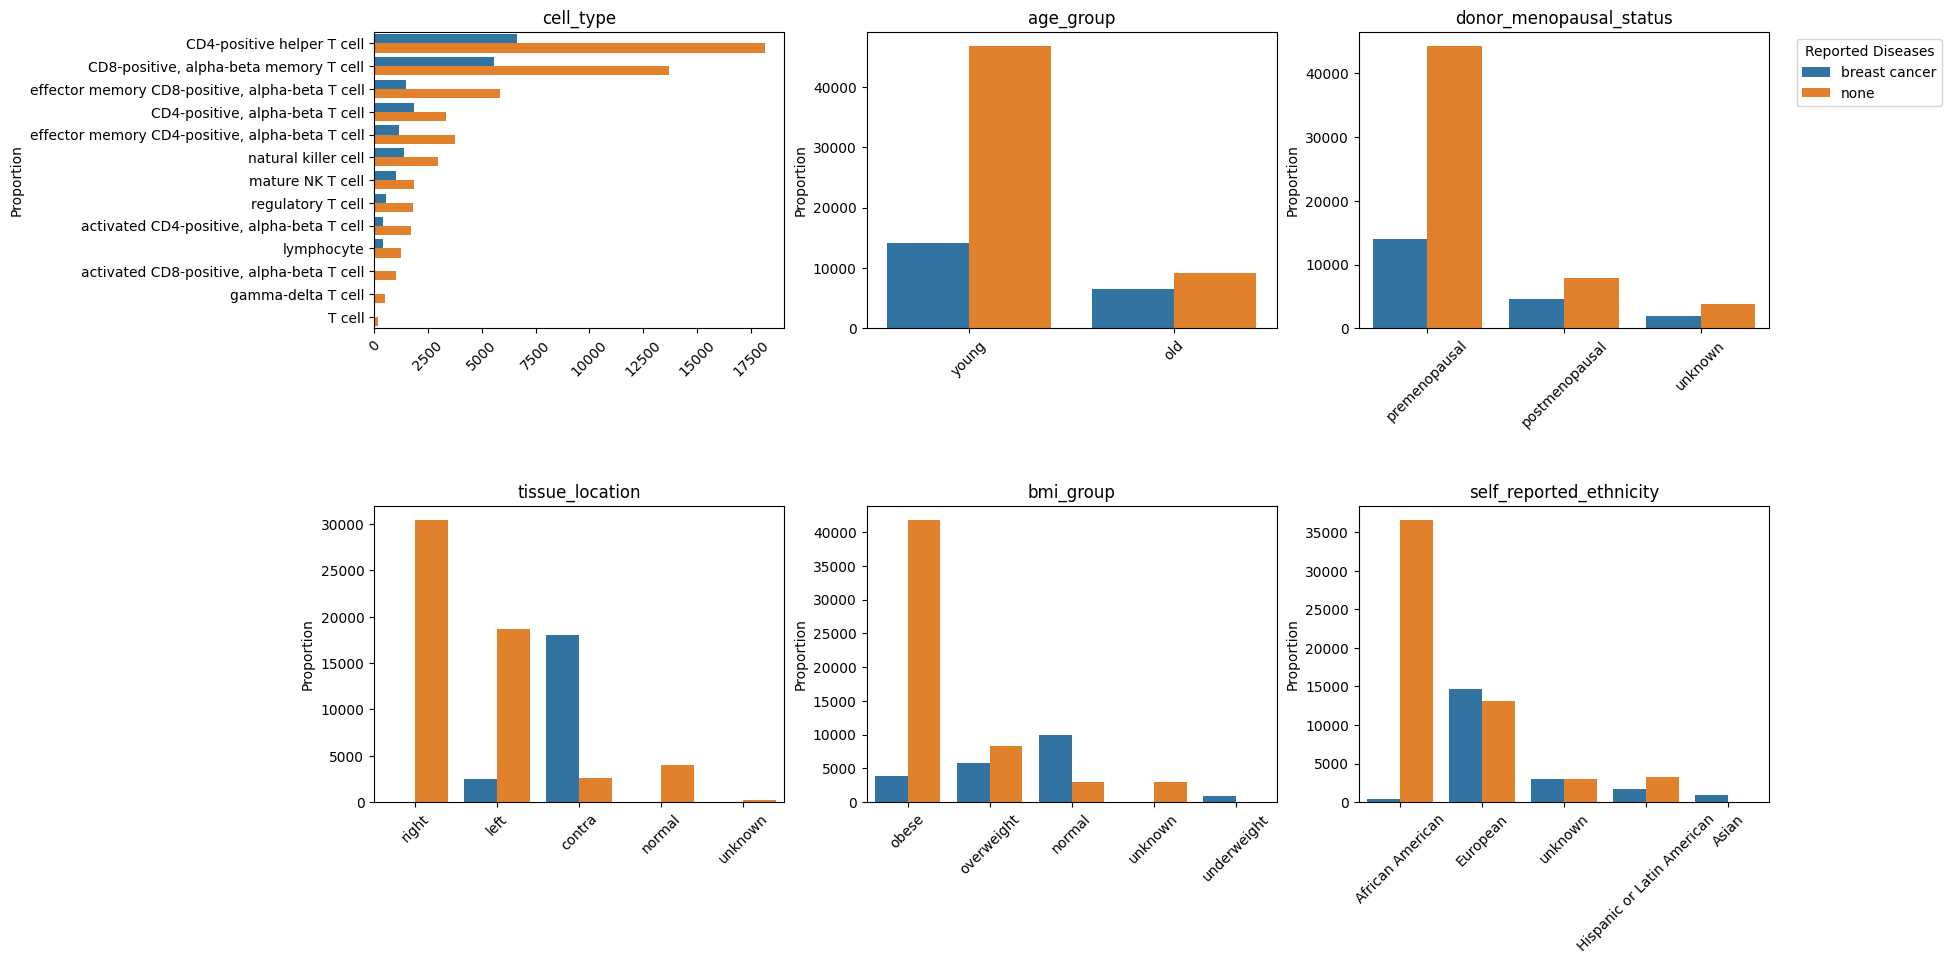

In [21]:
categorical_vars = ['cell_type', 'age_group','donor_menopausal_status','tissue_location','bmi_group','self_reported_ethnicity']
fig,axis = plt.subplots(2,3,figsize=(18,10))
axis=axis.ravel()
for id,var in enumerate(categorical_vars):
    if var == 'cell_type':
        sns.countplot(y=var, data=adata.obs, order=adata.obs[var].value_counts().index,ax=axis[id], hue='reported_diseases')
    else:
        sns.countplot(x=var, data=adata.obs, order=adata.obs[var].value_counts().index,ax=axis[id], hue='reported_diseases')

        # Set title and labels
    axis[id].set_title(var)
    axis[id].set_ylabel('Proportion')
    axis[id].set_xlabel('')
    axis[id].set_xticklabels(axis[id].get_xticklabels(),rotation=45)
    axis[id].legend('')
    
    if id != 2:
        axis[id].get_legend().remove()

handles, labels = axis[2].get_legend_handles_labels()
axis[2].legend(handles, labels, title='Reported Diseases', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(hspace=0.6)

1) As expected looks like most of the cell types are CD4-positive helper T cell and CD8-positive alpha beta memory T cell. It looks like some cell type are not cancer at all. 
2) most donors are yong and therefor premenopausal. 
3) cells taken from right/normal tissue do not have any classified as cancer.
4) Most are over weight or obese. all the underweight donors have cells classified as cancer. 
5) Most are from an african american or european ethnicity.   

This needs to be taking into account, that the models that train to classify may only work for women in this ethnicity and age group.    

For a more in-depth look into the proportion of the labels in each feature: 

In [22]:
'''
color_mapping = {
    'none': 'lightcoral',  
    'breast cancer': 'darkred'   
}

categorical_vars = ['cell_type', 'age_group', 'tissue_location','donor_menopausal_status', 'bmi_group', 'self_reported_ethnicity']
fig, axis = plt.subplots(2, 3, figsize=(15, 10))
axis = axis.ravel()

for id, var in enumerate(categorical_vars):
    # Get counts of 'reported_diseases' per category in 'var'
    counts = pd.crosstab(adata.obs[var], adata.obs['reported_diseases'], normalize='index')
    
    if var == "cell_type":
        counts.plot(kind='barh', stacked=True, ax=axis[id], color=[color_mapping[col] for col in counts.columns]) 
    else:
        counts.plot(kind='bar', stacked=True, ax=axis[id], color=[color_mapping[col] for col in counts.columns]) 

    
    # Set title and labels
    axis[id].set_title(var)
    axis[id].set_ylabel('Proportion')
    axis[id].set_xlabel('')
    axis[id].legend('')
    # Remove legend from subplots other than the fourth one
    if id != 2:
        axis[id].get_legend().remove()

# Add legend to the fourth subplot (index 3)
handles, labels = axis[2].get_legend_handles_labels()
axis[2].legend(handles, labels, title='Reported Diseases', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(hspace=0.3, right=0.8)
'''

'\ncolor_mapping = {\n    \'none\': \'lightcoral\',  \n    \'breast cancer\': \'darkred\'   \n}\n\ncategorical_vars = [\'cell_type\', \'age_group\', \'tissue_location\',\'donor_menopausal_status\', \'bmi_group\', \'self_reported_ethnicity\']\nfig, axis = plt.subplots(2, 3, figsize=(15, 10))\naxis = axis.ravel()\n\nfor id, var in enumerate(categorical_vars):\n    # Get counts of \'reported_diseases\' per category in \'var\'\n    counts = pd.crosstab(adata.obs[var], adata.obs[\'reported_diseases\'], normalize=\'index\')\n    \n    if var == "cell_type":\n        counts.plot(kind=\'barh\', stacked=True, ax=axis[id], color=[color_mapping[col] for col in counts.columns]) \n    else:\n        counts.plot(kind=\'bar\', stacked=True, ax=axis[id], color=[color_mapping[col] for col in counts.columns]) \n\n    \n    # Set title and labels\n    axis[id].set_title(var)\n    axis[id].set_ylabel(\'Proportion\')\n    axis[id].set_xlabel(\'\')\n    axis[id].legend(\'\')\n    # Remove legend from subplo

### Differences in effect between the different assays 

I will look to see if there is a visible difference in the mean expression for all genes in each assay type

In [23]:
assay_type_1 = "10x 3' v2"
assay_type_2 = "10x 3' v3"

samples_assay_1 = adata.obs[adata.obs['assay'] == assay_type_1].index
samples_assay_2 = adata.obs[adata.obs['assay'] == assay_type_2].index

adata_assay_1 = adata[samples_assay_1, :]
adata_assay_2 = adata[samples_assay_2, :]

In [24]:
assay1_df = adata_assay_1.to_df()
assay2_df = adata_assay_2.to_df()

In [25]:
assay1_mean_gene_expression = assay1_df.mean()
assay2_mean_gene_expression = assay2_df.mean()

df_assay_expression = pd.concat([assay1_mean_gene_expression, assay2_mean_gene_expression], axis=1)
df_assay_expression = df_assay_expression.rename(columns={0: "10x 3' v2", 1: "10x 3' v3"})

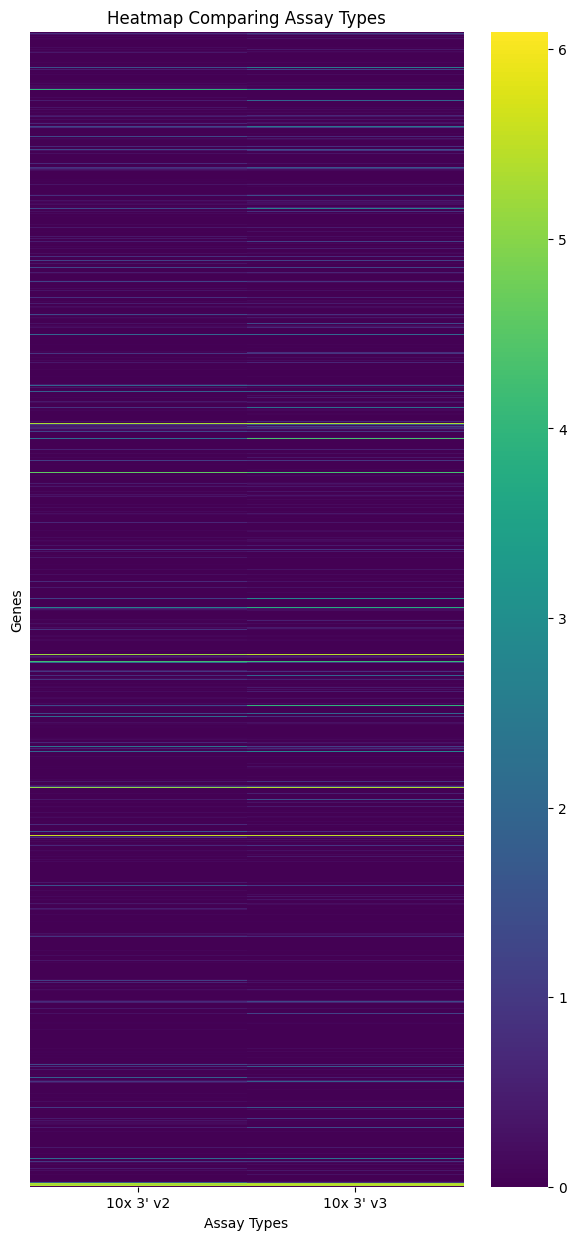

In [26]:
plt.figure(figsize=(7, 15))
sns.heatmap(df_assay_expression, cmap='viridis', cbar=True ,yticklabels=False)

plt.title('Heatmap Comparing Assay Types')
plt.xlabel('Assay Types')
plt.ylabel('Genes')

plt.show()

could this difference be due to differences in amount of cancer cells in each assay ?

In [27]:
series1 = pd.Series(adata_assay_1.obs.reported_diseases.value_counts(normalize=True), name="10x 3' v2")
series2 = pd.Series(adata_assay_2.obs.reported_diseases.value_counts(normalize=True), name="10x 3' v3")

df = pd.concat([series1, series2], axis=1).reset_index()

In [28]:
df

,reported_diseases,10x 3' v2,10x 3' v3
0,breast cancer,0.611097,0.250447
1,none,0.388903,0.749553


Looks like there is a difference between the assay types, some genes are highly expressed in one but not the other. In addition, each assay has a very different proportion of the label class. 

## Latent single-cell representation
To create the most biologically meaningful embeddings for the cells, it is best to add other relevant features to the cell expression. In order to do so, I will transform the `cell_type` feature to numerical and create an embedding matrix that learns informative representations for each value. Then I will append the embeddings to the expression vector. 

In addition, I will preform some hyperparameter turning for the lr and latent dimension. 

My plan: 
1. Split the data into train and test.
2. Process data for pytorch by converting to tensors and `DataLoader` object. 
3. Define my auto encoder architecture with encoder and decoder attributes and a feed forward method.
4. Define training and evaluation loop with some hyper-parameter tuning 
5. Re-train my model with the best parameters
6. Extract cell representations 
7. Finish off with a comparison to PCA representations


In [29]:
batch_size = 64
embedding_dim = 16  
learning_rates = [1e-4,1e-5,1e-6]
latent_dims = [32, 64, 128]

In [30]:
cell_types = adata.obs['cell_type'].values
label_encoder = LabelEncoder()
cell_types_encoded = label_encoder.fit_transform(cell_types)
num_cell_types = len(label_encoder.classes_)

In [31]:
X_train, X_test, cell_type_train, cell_type_test = train_test_split(
    adata.X.toarray(), cell_types_encoded, test_size=0.2, random_state=42
)

X_tensor = torch.tensor(adata.X.toarray(), dtype=torch.float32)
all_cell_types_tensor = torch.tensor(cell_types_encoded, dtype=torch.long)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
cell_type_train_tensor = torch.tensor(cell_type_train, dtype=torch.long)
cell_type_test_tensor = torch.tensor(cell_type_test, dtype=torch.long) # why long?

train_dataset = TensorDataset(X_train_tensor, cell_type_train_tensor, X_train_tensor)  
test_dataset = TensorDataset(X_test_tensor, cell_type_test_tensor, X_test_tensor)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) # why shuffle 


print(f"Total number of sampling in train set: {X_train_tensor.shape[0]}")
print(f"Total number of sampling in test set: {X_test_tensor.shape[0]}")

Total number of sampling in train set: 61253
Total number of sampling in test set: 15314


#### Define class for auto encoder , training and evaluation 

In [32]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int,num_cell_types: int,embedding_dim: int):
        super(Autoencoder, self).__init__()

        self.cell_type_embedding = nn.Embedding(num_cell_types, embedding_dim)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + embedding_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, latent_dim),
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, input_dim),
        )
    
    def forward(self, x, cell_type_ids):
        cell_type_embedding = self.cell_type_embedding(cell_type_ids)
        x_combined = torch.cat([x, cell_type_embedding], dim=1)
        encoded = self.encoder(x_combined)
        decoded = self.decoder(encoded)
        return decoded

In [33]:
def train_autoencoder(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, optimizer, criterion, epochs=100,verbose=False): 
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for inputs, cell_type_batch, _ in train_dataloader:

            outputs = model(inputs, cell_type_batch)
            loss = criterion(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()  

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  

        model.eval() 
        test_loss = 0
        with torch.no_grad(): 

            for inputs, cell_type_batch, _ in test_loader:
                
                outputs = model(inputs, cell_type_batch)
                loss = criterion(outputs, inputs)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)  
        test_losses.append(avg_test_loss) 
        if verbose:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
            
    final_test_loss = test_losses[-1]
    return final_test_loss

#### The training and evaluation loop

I will be using MSE loss because this is a regression problem and choosing my best model by the lowest loss achieved on the last epoch 

In [34]:
input_dim = X_train_tensor.shape[1]  
best_loss = float('inf')
best_params = None

for latent_dim in latent_dims:
    for lr in learning_rates:
        print("-----------------------------------------------------")
        print(f"Tuning with lr={lr}, latent_dim={latent_dim}")
        
        model = Autoencoder(input_dim=X_train.shape[1], latent_dim=64, num_cell_types=num_cell_types, embedding_dim=embedding_dim)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss() 
        last_epoch_test_loss = train_autoencoder(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=15, verbose=True)

        if last_epoch_test_loss < best_loss:
            best_loss = last_epoch_test_loss
            best_params = {'learning_rate': lr, 'latent_dim': latent_dim}

print(f"Best Test Loss: {best_loss:.4f} with parameters: {best_params}")

-----------------------------------------------------
Tuning with lr=0.0001, latent_dim=32
Epoch [1/15], Train Loss: 0.6185, Test Loss: 0.3813
Epoch [2/15], Train Loss: 0.3545, Test Loss: 0.3245
Epoch [3/15], Train Loss: 0.3075, Test Loss: 0.2889
Epoch [4/15], Train Loss: 0.2810, Test Loss: 0.2705
Epoch [5/15], Train Loss: 0.2714, Test Loss: 0.2729
Epoch [6/15], Train Loss: 0.2671, Test Loss: 0.2628
Epoch [7/15], Train Loss: 0.2643, Test Loss: 0.2690
Epoch [8/15], Train Loss: 0.2628, Test Loss: 0.2596
Epoch [9/15], Train Loss: 0.2614, Test Loss: 0.2707
Epoch [10/15], Train Loss: 0.2606, Test Loss: 0.2589
Epoch [11/15], Train Loss: 0.2596, Test Loss: 0.9837
Epoch [12/15], Train Loss: 0.2592, Test Loss: 0.7025
Epoch [13/15], Train Loss: 0.2584, Test Loss: 5.9390
Epoch [14/15], Train Loss: 0.2576, Test Loss: 1.0617
Epoch [15/15], Train Loss: 0.2572, Test Loss: 17.3092
-----------------------------------------------------
Tuning with lr=1e-05, latent_dim=32
Epoch [1/15], Train Loss: 0.9522

This training is a great example of either a lr thats too small or too large. It looks like to sweat spot is 0.00001. 
With a lr of 0.0001 , you can see the loss going down quickly, the steps are large, but this causes the model to overshoot the optimal parameters. 
With a lr of 0.00001 the loss converges nicely, but it looks like it gets stuck in a local minimum, so it doesnt reach the optimal global minimum. 
with a lr of 0.000001 the steps are too small and the model doesnt reach the local or global minimum. 

#### Re-training with best parameters 

I know this is computationally wasteful, best practice is to create .ckpt of the model, if i had more time I would add this feature. 

In [35]:
model = Autoencoder(input_dim=input_dim, latent_dim=32, num_cell_types=num_cell_types, embedding_dim=embedding_dim)

In [36]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.MSELoss() 
_ = train_autoencoder(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=10, verbose=False)

#### Saving best model representations to data object 

In [37]:
cell_type_embedding = nn.Embedding(num_cell_types, embedding_dim)

In [38]:
cell_type_embeddings = model.cell_type_embedding(all_cell_types_tensor)
x_combined = torch.cat([X_tensor, cell_type_embeddings], dim=1)

In [39]:
auto_encoder_representations = model.encoder(x_combined).detach().numpy()

In [40]:
adata.obsm['X_ae'] = auto_encoder_representations

#### Compare to PCA representations: 

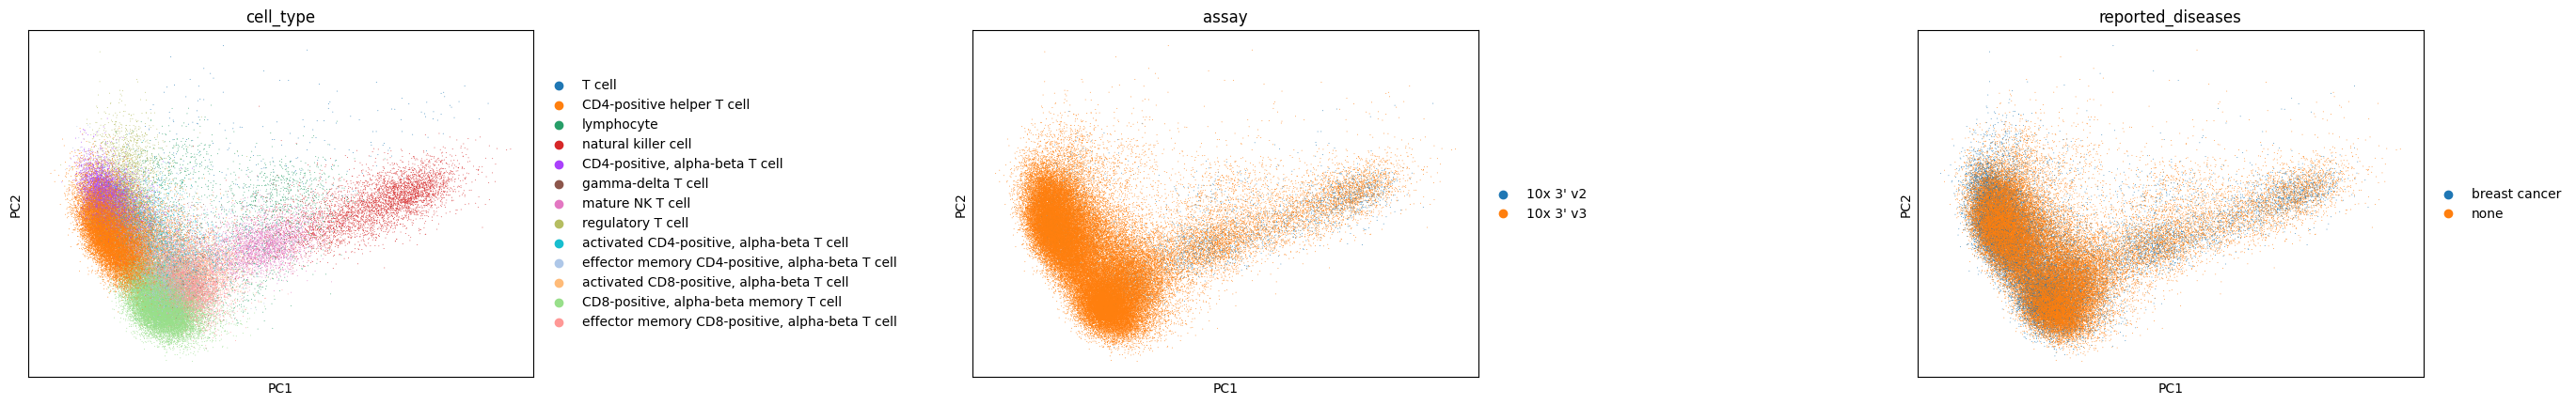

In [41]:
sc.pl.pca(adata, color=['cell_type','assay','reported_diseases'],wspace=0.7)

In [42]:
sc.pp.neighbors(adata, use_rep='X_ae')
sc.tl.umap(adata, min_dist=0.3)

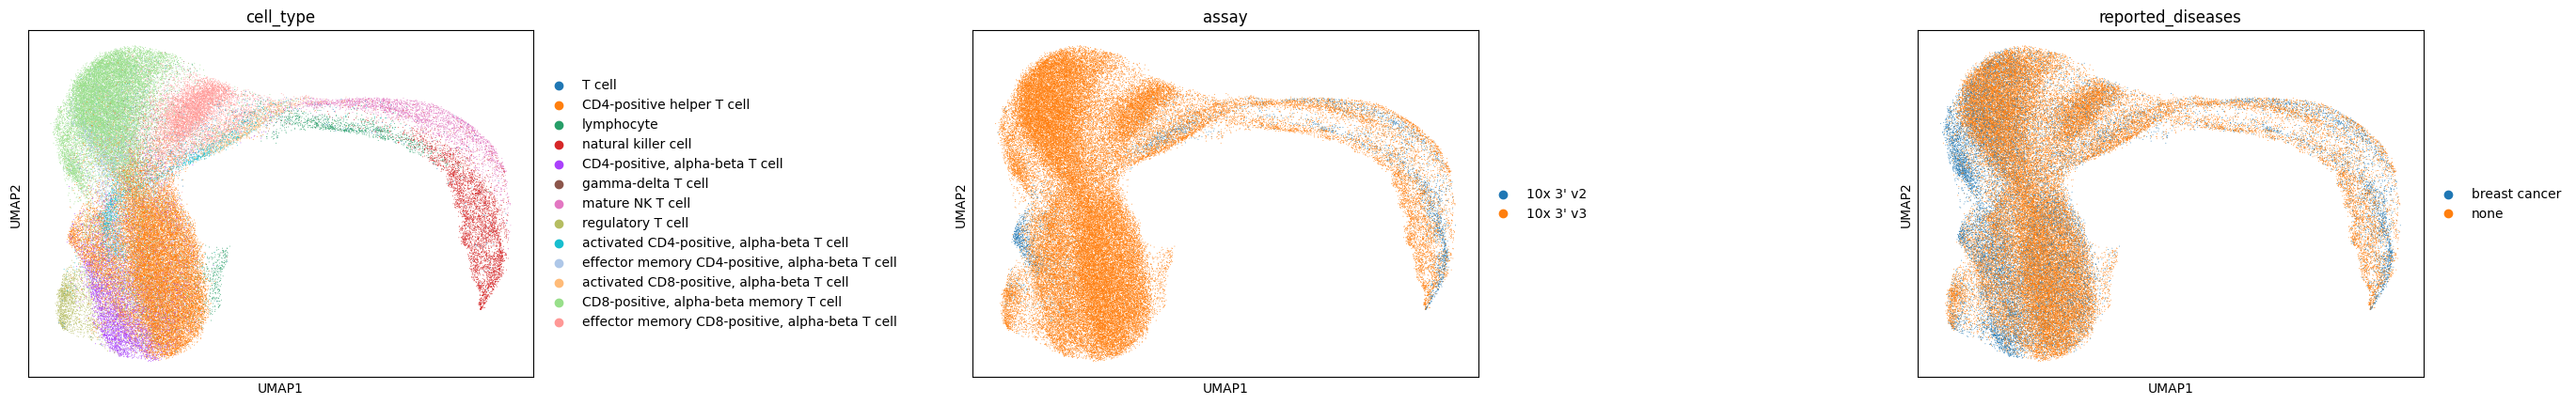

In [43]:
sc.pl.umap(
    adata,
    color=["cell_type","assay","reported_diseases"],wspace=0.7,
)

Looks like both representations dont cluster by the `assay` confounder. Meaning this batch effect looks canceled out. In terms of the UMAP and PCA plot, it looks like each representation clusters a different cell type better, both do not look like they cluster the cell types very well.  

In [44]:
silhouette_score(adata.obsm['X_pca'], adata.obs.cell_type)

0.11516140953021237

In [45]:
silhouette_score(adata.obsm['X_ae'], adata.obs.cell_type)

0.053610828

silhouette score is higher for PCA, so the PCA representations cluster cell type better than the AE representations.

## Predicting disease state from your latent representation.

I will be using two classic classifiers: logistic regression and random forrest. 

For the metrics I will look at F1 score and ROC-AUC score: 
1) F1 score: Balances the trade-off between precision and recall, good for tasks like this where the costs of false positives and false negatives are significant.
2) ROC-AUC score: Measures the ability of a model to distinguish between classes across all classification thresholds.


In [46]:
label_column = 'reported_diseases'
donor_column = 'donor_id'

raw_X = adata.to_df()
pca_X = pd.DataFrame(adata.obsm['X_pca'])
ae_X = pd.DataFrame(adata.obsm['X_ae'])

y = adata.obs[label_column].values
y = np.where(y == "breast cancer", 1, 0)
donor_ids = adata.obs[donor_column].values

In [47]:
train_idx, test_idx = train_test_split(range(len(donor_ids)), stratify=donor_ids, test_size=0.2, random_state=42)

X_train_raw, X_test_raw = raw_X.iloc[train_idx], raw_X.iloc[test_idx]
X_train_pca, X_test_pca = pca_X.iloc[train_idx], pca_X.iloc[test_idx]
X_train_ae, X_test_ae = ae_X.iloc[train_idx], ae_X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [48]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_raw, y_train)
y_dummy_pred = dummy_clf.predict(X_test_raw)

print("Dummy Classifier Report:")
print(classification_report(y_test, y_dummy_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_dummy_pred):.4f}")

Dummy Classifier Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84     11202
           1       0.00      0.00      0.00      4112

    accuracy                           0.73     15314
   macro avg       0.37      0.50      0.42     15314
weighted avg       0.54      0.73      0.62     15314

ROC-AUC: 0.5000


As predicted, the dummy classifier got an AUC of 0.5 meaning that it is random. The data is imbalanced therefore it is important *not* to look at metrics like accuracy. I will be using F1 score and ROC-AUC score for model evaluation.

### Define pipeline and CV 

In [49]:
pipelines = {
    'Logistic Regression': Pipeline([
        ('normalizer', StandardScaler()), # read more about why to normalize for lg
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000,random_state=42)) 
    ]),
    'Random Forest': Pipeline([
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, class_weight='balanced' ))
    ])
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scorer = make_scorer(roc_auc_score)

As part of the effort to deal with the imbalanced dataset, I will use a stratified kfolds. The stratified k-fold cross validation ensures each fold’s sample is randomly selected without replacement, to reflect the ratio imbalance distribution of the target feature in the data.

### EVALUATION

In [50]:
def evaluate_model(pipelines, X_train, X_test, y_train, y_test, cv=5,explainability=False):
    results = {}
    for name, pipeline in pipelines.items():
        print(f"\n{name} Performance:")
        
        cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, 
                                    scoring=['roc_auc', 'f1'], 
                                    return_train_score=False)
        
        results[name] = {
            'mean_roc_auc': cv_results['test_roc_auc'].mean(),
            'std_roc_auc': cv_results['test_roc_auc'].std(),
            'mean_f1': cv_results['test_f1'].mean(),
            'std_f1': cv_results['test_f1'].std()
        }
        
        print(f"Cross-Validation ROC-AUC Mean: {results[name]['mean_roc_auc']:.4f} ± {results[name]['std_roc_auc']:.4f}")
        print(f"Cross-Validation F1 Score Mean: {results[name]['mean_f1']:.4f} ± {results[name]['std_f1']:.4f}")

        # Fit and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
        # Compute ROC-AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        test_roc_auc = roc_auc_score(y_test, y_prob)
        
        # Compute F1 score
        test_f1_score = f1_score(y_test, y_pred)
        
        print(f"Test Set ROC-AUC: {test_roc_auc:.4f}")
        print(f"Test Set F1 Score: {test_f1_score:.4f}")
        
        # Compute and print confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        results[name]['cm'] = cm

        # feature importance 
        if explainability:
            if isinstance(pipeline.named_steps['clf'], RandomForestClassifier):
                explainer = shap.TreeExplainer(pipeline.named_steps['clf'])
                print('Using TreeExplainer')
            elif isinstance(pipeline.named_steps['clf'], LogisticRegression):
                explainer = shap.LinearExplainer(pipeline.named_steps['clf'],X_test)
                print('Using LinearExplainer')
            else:
                raise ValueError(f"SHAP explainer not supported for {name}")
            
            results[name]['shap'] = explainer.shap_values(X_test)


        # Store metrics
        results[name]['fpr'] = fpr
        results[name]['tpr'] = tpr
        results[name]['roc_auc_test'] = test_roc_auc
        results[name]['roc_auc'] = roc_auc
        results[name]['f1_score'] = test_f1_score
    
    return results

In [51]:
def plot_cm(results):
    _ , axis = plt.subplots(1,2,figsize=(8, 3))
    sns.heatmap(results['Logistic Regression']['cm'], annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cancerous', 'Cancerous'], yticklabels=['Not Cancerous', 'Cancerous'],cbar=False,ax=axis[0])
    axis[0].set_xlabel('Predicted')
    axis[0].set_ylabel('Actual')
    axis[0].set_title('Logistic Regression')

    sns.heatmap(results['Random Forest']['cm'], annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cancerous', 'Cancerous'], yticklabels=['Not Cancerous', 'Cancerous'],cbar=False,ax=axis[1])
    axis[1].set_xlabel('Predicted')
    axis[1].set_ylabel('Actual')
    axis[1].set_title('Random Forest')

def plot_shap(results,X_test):
    plt.figure(figsize=(10, 8))
    shap.summary_plot(results['Logistic Regression']['shap'], X_test, max_display=10, feature_names=X_test.columns, show=False)
    plt.title('Logistic Regression')


def plot_roc_auc_curve(results_raw, results_pca, results_ae):

    plt.figure(figsize=(6, 4))
    
    plt.plot(results_raw['fpr'], results_raw['tpr'], label=f"Raw (AUC = {results_raw['roc_auc']:.2f})", color='blue')
    plt.plot(results_pca['fpr'], results_pca['tpr'], label=f"PCA (AUC = {results_pca['roc_auc']:.2f})", color='green')
    plt.plot(results_ae['fpr'], results_ae['tpr'], label=f"AE (AUC = {results_ae['roc_auc']:.2f})", color='red')

    plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, alpha=0.7)  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



In [52]:
print('Raw')
results_raw = evaluate_model(pipelines, X_train_raw, X_test_raw, y_train, y_test,cv=cv,explainability=True)
print('------------------------------------------')
print('PCA')
results_pca = evaluate_model(pipelines, X_train_pca, X_test_pca, y_train, y_test,cv=cv)
print('------------------------------------------')
print('AE')
results_ae = evaluate_model(pipelines, X_train_ae, X_test_ae, y_train, y_test,cv=cv)
print('------------------------------------------')

Raw

Logistic Regression Performance:
Cross-Validation ROC-AUC Mean: 0.7997 ± 0.0055
Cross-Validation F1 Score Mean: 0.5941 ± 0.0069
Test Set ROC-AUC: 0.8093
Test Set F1 Score: 0.6045
Using LinearExplainer

Random Forest Performance:
Cross-Validation ROC-AUC Mean: 0.7909 ± 0.0037
Cross-Validation F1 Score Mean: 0.5696 ± 0.0068
Test Set ROC-AUC: 0.7884
Test Set F1 Score: 0.5686
Using TreeExplainer
------------------------------------------
PCA

Logistic Regression Performance:
Cross-Validation ROC-AUC Mean: 0.7056 ± 0.0050
Cross-Validation F1 Score Mean: 0.4989 ± 0.0051
Test Set ROC-AUC: 0.7083
Test Set F1 Score: 0.4996

Random Forest Performance:
Cross-Validation ROC-AUC Mean: 0.7616 ± 0.0047
Cross-Validation F1 Score Mean: 0.5464 ± 0.0054
Test Set ROC-AUC: 0.7585
Test Set F1 Score: 0.5426
------------------------------------------
AE

Logistic Regression Performance:
Cross-Validation ROC-AUC Mean: 0.7220 ± 0.0064
Cross-Validation F1 Score Mean: 0.5159 ± 0.0079
Test Set ROC-AUC: 0.7233

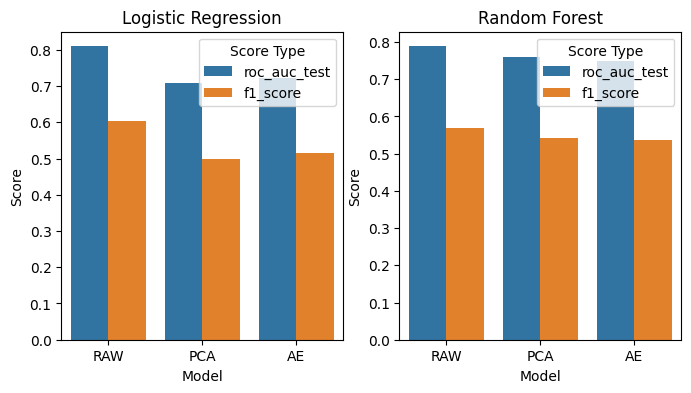

In [53]:
data_lg = {
    'Model': ['RAW', 'PCA', 'AE'],
    'roc_auc_test': [results_raw['Logistic Regression']['roc_auc_test'], results_pca['Logistic Regression']['roc_auc_test'], results_ae['Logistic Regression']['roc_auc_test']],
    'f1_score': [results_raw['Logistic Regression']['f1_score'], results_pca['Logistic Regression']['f1_score'], results_ae['Logistic Regression']['f1_score']]
}

data_rf = {
    'Model': ['RAW', 'PCA', 'AE'],
    'roc_auc_test': [results_raw['Random Forest']['roc_auc_test'], results_pca['Random Forest']['roc_auc_test'], results_ae['Random Forest']['roc_auc_test']],
    'f1_score': [results_raw['Random Forest']['f1_score'], results_pca['Random Forest']['f1_score'], results_ae['Random Forest']['f1_score']]
}

df_lg = pd.DataFrame(data_lg)
df_rf = pd.DataFrame(data_rf)

# Melt the DataFrame to long format
df_melted_lg = df_lg.melt(id_vars='Model', var_name='Score Type', value_name='Score')
df_melted_rf = df_rf.melt(id_vars='Model', var_name='Score Type', value_name='Score')

fig,axis = plt.subplots(1,2,figsize=(8,4))
sns.barplot(data=df_melted_lg, x='Model', y='Score', hue='Score Type',ax=axis[0])
axis[0].set_title('Logistic Regression')
sns.barplot(data=df_melted_rf, x='Model', y='Score', hue='Score Type',ax=axis[1])
axis[1].set_title('Random Forest')


# Add labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Score Type')

Looks like the raw representation with lg achieves the highest roc auc score and F1 score. 

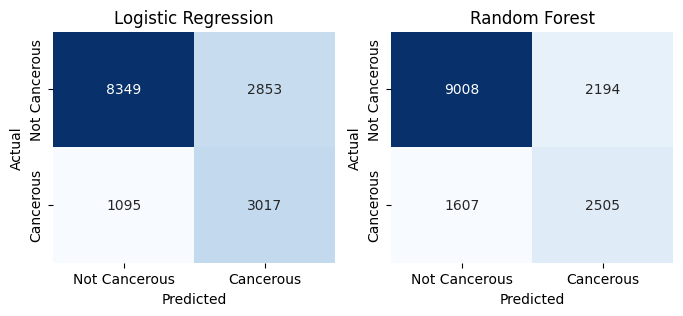

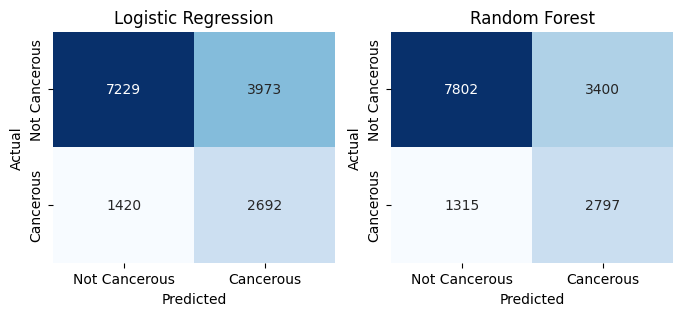

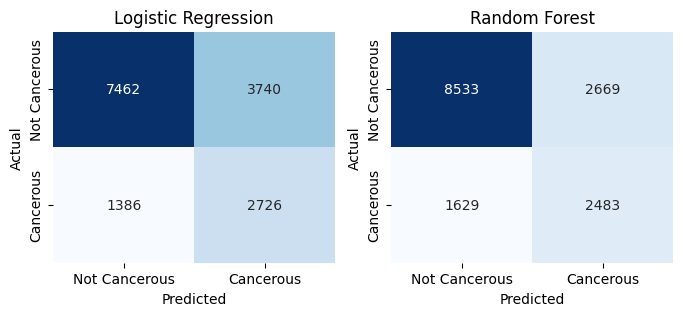

In [54]:
plot_cm(results_raw)
plot_cm(results_pca)
plot_cm(results_ae)

The confusion matrices make it easier to see that the raw representations with the logistic regression get the lowest number of false negatives. 
In this task, i think this is the most important metric to minimize due to the medical sensitivity. 

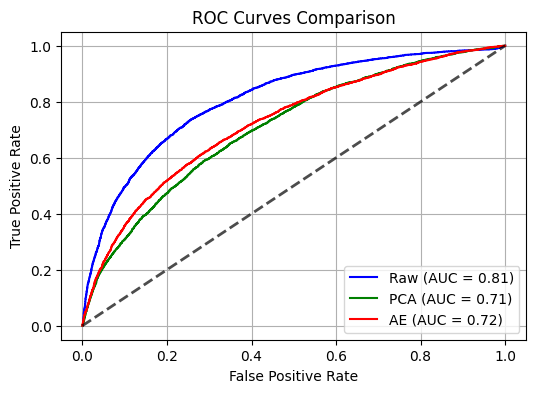

In [55]:
plot_roc_auc_curve(results_raw['Logistic Regression'],results_pca['Logistic Regression'],results_ae['Logistic Regression'])

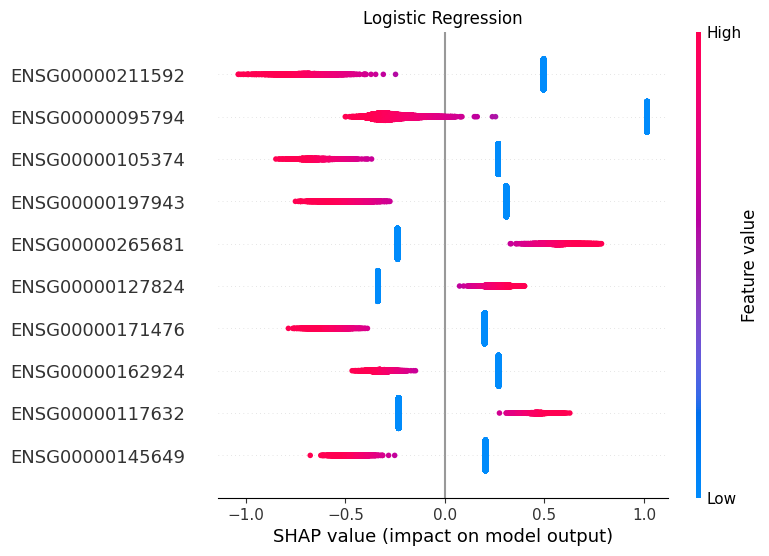

In [56]:
plot_shap(results_raw,X_test_raw)

The SHAP can help us a little regarding model expandability, showing the top 10 genes that influenced the classification, these genes would interesting to look into more, what is common between them?  what protein to they encode? 

I will try to add some L2 regularization and see if this improves the performance of the best performing model: LG on raw representations 

In [57]:
penalty_strength = [0.001, 0.01, 0.1, 1, 10, 100]
for penalty in penalty_strength:
    print(f"C = {penalty}")
    pipelines = {
        'Logistic Regression': Pipeline([
            ('normalizer', StandardScaler()), 
            ('clf', LogisticRegression(
                class_weight='balanced', 
                max_iter=1000, 
                penalty='l2',       
                C=penalty,              
                random_state=42
            )) 
        ])}


    results_raw = evaluate_model(pipelines, X_train_raw, X_test_raw, y_train, y_test,cv=cv,explainability=True)
    print('--------------------------------')

C = 0.001

Logistic Regression Performance:
Cross-Validation ROC-AUC Mean: 0.8058 ± 0.0056
Cross-Validation F1 Score Mean: 0.5969 ± 0.0069
Test Set ROC-AUC: 0.8140
Test Set F1 Score: 0.6026
Using LinearExplainer
--------------------------------
C = 0.01

Logistic Regression Performance:
Cross-Validation ROC-AUC Mean: 0.8020 ± 0.0057
Cross-Validation F1 Score Mean: 0.5946 ± 0.0070
Test Set ROC-AUC: 0.8110
Test Set F1 Score: 0.6045
Using LinearExplainer
--------------------------------
C = 0.1

Logistic Regression Performance:
Cross-Validation ROC-AUC Mean: 0.8002 ± 0.0055
Cross-Validation F1 Score Mean: 0.5941 ± 0.0070
Test Set ROC-AUC: 0.8096
Test Set F1 Score: 0.6043
Using LinearExplainer
--------------------------------
C = 1

Logistic Regression Performance:
Cross-Validation ROC-AUC Mean: 0.7997 ± 0.0055
Cross-Validation F1 Score Mean: 0.5941 ± 0.0069
Test Set ROC-AUC: 0.8093
Test Set F1 Score: 0.6045
Using LinearExplainer
--------------------------------
C = 10

Logistic Regression

C=0.001 improves the ROC-AUC score slightly, doesn't look like the regularization improves the classification metrics. 

This may be due to a need for using a different method like L1, maybe there needs to be some more data balancing before, maybe my model is already too simple and is underfitting so regularization isnt going to help. 